<h1>Inhaltsverzeichnis<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Verschiedene-Bilder-Suchen" data-toc-modified-id="Verschiedene-Bilder-Suchen-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Verschiedene Bilder Suchen</a></span><ul class="toc-item"><li><span><a href="#Bilder-herunterladen" data-toc-modified-id="Bilder-herunterladen-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Bilder herunterladen</a></span></li><li><span><a href="#Modell-Trainieren" data-toc-modified-id="Modell-Trainieren-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Modell Trainieren</a></span></li></ul></li><li><span><a href="#Häufige-Fehler" data-toc-modified-id="Häufige-Fehler-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Häufige Fehler</a></span></li></ul></div>

# Ein eigenes Modell

## Verschiedene Bilder Suchen

Empfehlung: 3 Kategorien maximum

Beispiel:
Autos vs. Strassenschilder

Google-Bildersuche, in der Konsole eingeben:

```
urls = Array.from(document.querySelectorAll('.rg_di .rg_meta')).map(el=>JSON.parse(el.textContent).ou);
window.open('data:text/csv;charset=utf-8,' + escape(urls.join('\n')));
```

und das Resultat dann speichern und importieren.

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.vision import Path

path = Path('data/verkehr')

autos_file = path / 'auto_urls.csv'
strassenschild_file = path /'strassenschild_urls.csv'

strassenschild_folder = path / 'strassenschild'
autos_folder = path / 'autos'

strassenschild_folder_path = strassenschild_folder.absolute()
autos_folder_path = autos_folder.absolute()

!rm $strassenschild_folder_path -rf
!rm $autos_folder_path -rf

strassenschild_folder.mkdir(parents=True, exist_ok=True)
autos_folder.mkdir(parents=True, exist_ok=True)

In [3]:
path.ls()

[PosixPath('data/verkehr/strassenschild_urls.csv'),
 PosixPath('data/verkehr/auto_urls.csv'),
 PosixPath('data/verkehr/strassenschild'),
 PosixPath('data/verkehr/models'),
 PosixPath('data/verkehr/autos')]

### Bilder herunterladen

In [4]:
from fastai.vision import download_images

In [5]:
download_images(autos_file, autos_folder, max_pics=200)

In [6]:
download_images(strassenschild_file, strassenschild_folder, max_pics=200)

In [7]:
from fastai.vision import verify_images


classes = ['autos','strassenschild']

for c in classes:
    print(c)
    verify_images(path/c, delete=True, max_size=500)

In [8]:
from fastai.vision import verify_images, np, get_transforms, imagenet_stats, ImageDataBunch

batch_size = 64

np.random.seed(42)
data = ImageDataBunch.from_folder(
    path, 
    bs=batch_size,
    train=".", 
    valid_pct=0.2,
    ds_tfms=get_transforms(), 
    size=224,
).normalize(imagenet_stats)

In [9]:
data.classes


['autos', 'strassenschild']

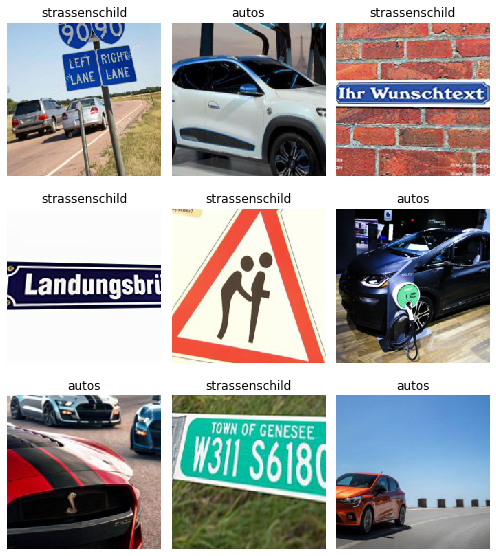

In [10]:
data.show_batch(rows=3, figsize=(7,8))


In [11]:
data.classes, data.c, len(data.train_ds), len(data.valid_ds)


(['autos', 'strassenschild'], 2, 152, 37)

### Modell Trainieren

In [12]:
from fastai.vision import cnn_learner, np, models, error_rate

learn = cnn_learner(data, models.resnet34, metrics=error_rate)

In [13]:
learn.fit_one_cycle(4)

In [14]:
learn.save('stage-1')

In [15]:
learn.unfreeze()

In [16]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


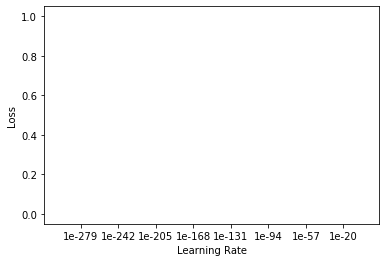

In [17]:
# Wenn nichts in der Grafik stehen sollte, mit konkreten Start/Endwerte probieren, zB
# learn.lr_find(start_lr=1e-5, end_lr=1e-1)
learn.recorder.plot()

In [18]:
learn.fit_one_cycle(2, max_lr=slice(3e-5,3e-4))


In [19]:
learn.save('stage-2')


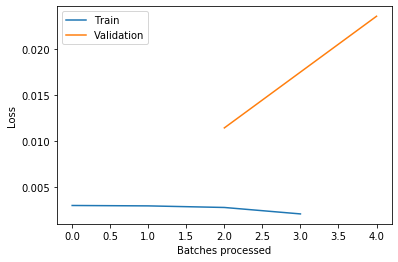

In [20]:
learn.recorder.plot_losses()

## Häufige Fehler

* Oftmals reichen die Standardwerte
* Tuning ist (entgegen den "tune your model" Ratgeber) nicht nötig - meistens
* die meisten Fehler stammen aus zwei Quellen:
    1. Lernrate zu hoch/tief
    2. Anzahl Trainings Epochen zu tief/hoch

In [20]:
# zu hohe Lernrate
learn = cnn_learner(data, models.resnet34, metrics=error_rate)
learn.fit_one_cycle(1, max_lr=0.5)

In [21]:
# zu tiefe Lernrate
learn = cnn_learner(data, models.resnet34, metrics=error_rate)
learn.fit_one_cycle(5, max_lr=1e-10)

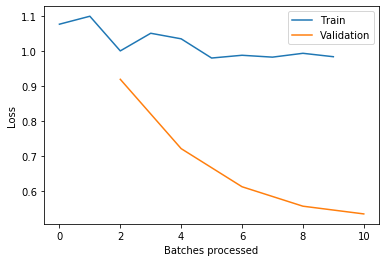

In [22]:
learn.recorder.plot_losses()

In [23]:
# zu wenig Epochen
learn = cnn_learner(data, models.resnet34, metrics=error_rate, pretrained=False)
learn.fit_one_cycle(1)

In [24]:
# zu viele Epochen
np.random.seed(42)
data = ImageDataBunch.from_folder(
    path, 
    train=".", 
    valid_pct=0.9, 
    bs=19,
    ds_tfms=get_transforms(
        do_flip=False, 
        max_rotate=0, 
        max_zoom=1, 
        max_lighting=0, 
        max_warp=0
    ),
    size=224, 
    num_workers=4
).normalize(imagenet_stats)

learn = cnn_learner(
    data, models.resnet50, metrics=error_rate, ps=0, wd=0
)
learn.unfreeze()

In [25]:
learn.fit_one_cycle(40, slice(1e-6,1e-4))

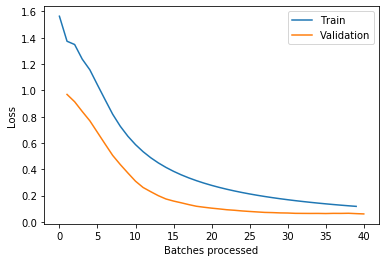

In [26]:
learn.recorder.plot_losses()